Meeting: 1st Nov saturday(insights)

What work i've done last time was with respect to training Wqk and Wov, and visuzlizing gradients in sync with parameters, loss, and accuracies.   

0. Explore more papers in this area.
1. Sir told to Train the last part Wqk and Wov which i've done last time, to predict only the last character to simplify further and we can have mathamatical analysis easy, which we can scale up for the full 16 character predictions.
2. Try to find the gradient of Wqk and Wov and analyse why it's behaving the way they are.
3. Since this problem is a linearly seperable problem so we can try to prove how the transformer model is performing this linear regression. 

## Ran below script on kaggle and got the model to re-run start from top only.

In [777]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt

# Check if MPS (Metal) is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
else: 
    device = torch.device("cpu")
print("Using device:", device)

# 1. Data Creation (ABCDEABCDE... pattern, with permutations) ie 5 cycle repeat
class ABCAlternatingPatternDataset(Dataset):
    def __init__(self, combinations, context_len=20, vocab_size=26):
        
        super().__init__()
        self.vocab_size = vocab_size
        self.context_len = context_len
        
        self.data, self.labels = [], []
        for (l1, l2, l3, l4, l5) in combinations:
            pattern = [l1, l2, l3, l4, l5] * ((context_len) // 4)
            seq = pattern[:context_len + 1]
            x = [ord(c) - 65 for c in seq[:context_len]]
            y = [ord(c) - 65 for c in seq[1:context_len + 1]]
            self.data.append(x)
            self.labels.append(y)
            
    def __getitem__(self, idx):
        return (
            torch.tensor(self.data[idx], dtype=torch.long),
            torch.tensor(self.labels[idx], dtype=torch.long),
        )
        
    def __len__(self):
        return len(self.data)

# 1.1 Train/Test Split 
def make_train_test_sets(num_train=600, num_test=100, context_len=20, vocab_size=26):
    alphabet = [chr(65 + i) for i in range(vocab_size)]
    all_combs = []
    for i in range(vocab_size):
        for j in range(vocab_size):
            for k in range(vocab_size):
                for l in range(vocab_size):
                    for m in range(vocab_size):
                        all_combs.append((alphabet[i], alphabet[j], alphabet[k], alphabet[l], alphabet[m]))
                        
    # Shuffle and sample for train/test
    random.shuffle(all_combs)
    train_combinations = all_combs[:num_train]
    test_combinations  = all_combs[num_train : num_train + num_test]
    train_set = ABCAlternatingPatternDataset(train_combinations, context_len, vocab_size)
    test_set  = ABCAlternatingPatternDataset(test_combinations,  context_len, vocab_size)
    
    return train_set, test_set

# 2. Custom Transformer Block (unchanged)
grad_Wqk, grad_Wov = [], []
Wqk, Wov = [], []
class ManualAttention(nn.Module):
    def __init__(self, embed_dim, vocab_size=26, num_heads=1, remove_bias=True):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        # self.Wq = nn.Parameter(torch.empty(num_heads, embed_dim, self.head_dim))
        # self.Wk = nn.Parameter(torch.empty(num_heads, embed_dim, self.head_dim))
        self.Wqk = nn.Parameter(torch.empty(num_heads, embed_dim, embed_dim))
        # self.Wv = nn.Parameter(torch.empty(num_heads, embed_dim, self.head_dim))
        # self.Wo = nn.Parameter(torch.empty(embed_dim, vocab_size))

        # only for one head!!!
        self.Wov = nn.Parameter(torch.empty(num_heads, embed_dim, vocab_size))
        nn.init.normal_(self.Wqk, mean=0, std=0.1)
        # nn.init.normal_(self.Wq, mean=0, std=0.1)
        # nn.init.normal_(self.Wk, mean=0, std=0.1)
        nn.init.normal_(self.Wov, mean=0, std=0.1)
        # nn.init.normal_(self.Wv, mean=0, std=0.1)
        # nn.init.normal_(self.Wo, mean=0, std=0.1)

        Wqk.append(self.Wqk.detach().cpu().clone())
        Wov.append(self.Wov.detach().cpu().clone())

        if not remove_bias:
            self.b_Wo = nn.Parameter(torch.zeros(embed_dim))
        else:
            self.register_parameter('b_Wo', None)
            
    def forward(self, x, mask=None):
        B, T, D = x.shape
        heads = []
        
        for i in range(self.num_heads):
            # Q = torch.matmul(x, self.Wq[i])
            # K = torch.matmul(x, self.Wk[i])
            x_wqk = torch.matmul(x, self.Wqk[i])
            QK = torch.matmul(x_wqk, x.transpose(-2, -1))
            # V = torch.matmul(x, self.Wv[i])
            scores = QK / (self.head_dim ** 0.5)
            if mask is not None:
                scores = scores.masked_fill(mask == 1, float('-1e9'))
            attn_weights = torch.softmax(scores, dim=-1)
            attn_weights = torch.nan_to_num(attn_weights, nan=0.0, posinf=0.0, neginf=0.0)
            # H = torch.matmul(attn_weights, V)
            # heads.append(H)
            out = attn_weights @ x @ self.Wov[i]
        # concat = torch.cat(heads, dim=-1)
        # out = concat @ self.Wo
        if self.b_Wo is not None:
            out = out + self.b_Wo
        return out

# 3. Simple Transformer Model
class SimpleTransformerScratch(nn.Module):
    def __init__(self,
                 vocab_size=26,
                 context_len=20,
                 embed_dim=26,
                 num_heads=1,
                 use_mlp=False,
                 mlp_hidden_dim=32,
                 use_identity_embedding=True,
                 use_identity_unembedding=True,
                 use_positional_encoding=False,
                 use_layernorm=False,
                 remove_bias=True):
        
        super().__init__()
        self.context_len = context_len
        self.embed_dim = embed_dim

        self.token_embedding_dim = embed_dim
        self.input_dim = vocab_size 
        # self.positional_dim = self.input_dim - self.token_embedding_dim  # allows dynamic computation

        if use_positional_encoding:
            # self.pos_embedding = nn.Parameter(torch.randn(1, context_len, self.positional_dim))
            self.pos_embedding = torch.eye(context_len).unsqueeze(0)
            self.register_buffer("pos_embedding_fixed", self.pos_embedding)
            self.positional_dim = context_len
        else:
            self.register_parameter("pos_embedding", None)
            self.positional_dim = 0
        
        if use_identity_embedding:
            self.embedding = nn.Embedding(vocab_size, vocab_size)
            with torch.no_grad():
                self.embedding.weight.copy_(torch.eye(vocab_size))
            self.embedding.weight.requires_grad = False
            embed_dim = vocab_size
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.use_positional_encoding = use_positional_encoding
        
        self.concat_dim = self.token_embedding_dim + self.positional_dim
        self.attn_block = ManualAttention(embed_dim=self.concat_dim, vocab_size=vocab_size, num_heads=num_heads, remove_bias=remove_bias)

        if use_mlp:
            self.ff1 = nn.Linear(self.concat_dim, mlp_hidden_dim, bias=not remove_bias)
            self.ff2 = nn.Linear(mlp_hidden_dim, self.concat_dim, bias=not remove_bias)
            self.act = nn.ReLU()
        else:
            self.ff1 = nn.Identity()
            self.ff2 = nn.Identity()
            self.act = nn.Identity()
        if use_layernorm:
            self.ln1 = nn.LayerNorm(self.concat_dim)
            self.ln2 = nn.LayerNorm(self.concat_dim) if use_mlp else nn.Identity()
        else:
            self.ln1 = nn.Identity()
            self.ln2 = nn.Identity()
        if use_identity_unembedding: 
            self.output_proj = nn.Identity()
        else:
            self.output_proj = nn.Linear(self.concat_dim, vocab_size, bias=not remove_bias)
            
    # no residual connenctions
    def forward(self, x):
        emb = self.embedding(x)
        # one_hot = torch.nn.functional.one_hot(x, num_classes=self.vocab.size).float()
        if self.use_positional_encoding and self.pos_embedding is not None:
            # Expand pos_embedding to full batch, then concatenate on last (embedding) dimension
            emb = torch.cat([emb, self.pos_embedding[:, :emb.size(1), :].expand(emb.size(0), -1, -1).to(emb.device)], dim=-1)
        T = x.size(1)
        mask = torch.triu(torch.ones(T, T, device=emb.device), diagonal=1).bool().unsqueeze(0)
        hidden = self.attn_block(emb, mask)
        residual = hidden # + emb
        # residual = self.ln1(residual)
        # ff_out = self.ff2(self.act(self.ff1(residual)))
        # residual = residual + ff_out
        # residual = self.ln2(residual)
        logits = self.output_proj(residual) # identity
        return logits

# 5. Training & Evaluation 
def train_model(model, train_loader, test_loader, device, epochs=10, lr=0.1):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_loss_list, test_acc_list, train_accuracy_list = [], [], []
    
    for epoch in range(epochs):
        model.train()
        total_loss, steps = 0., 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device) # x: [100, 20], y: [100, 20]
            logits = model(x) # logits: [100, 20, 26]
            # computing loss skipping first 5 token prediction for each prompt.
            logits_for_loss = logits[:, 19, :] # [100, 1, 26]
            y_for_loss = y[:, 19] # [100, 1]
            loss = criterion(logits_for_loss.reshape(-1, logits_for_loss.size(-1)), y_for_loss.reshape(-1)) 
            optimizer.zero_grad() # this is important to avoid gradient accumulation.
            loss.backward()

            attn = model.attn_block
            Wqk_grad = attn.Wqk.grad[0].detach().cpu()
            Wov_grad = attn.Wov.grad[0].detach().cpu()
            grad_Wqk.append(Wqk_grad)
            grad_Wov.append(Wov_grad)

            Wqk.append(attn.Wqk.detach().cpu().clone())
            Wov.append(attn.Wov.detach().cpu().clone())

            optimizer.step()
            total_loss += loss.item(); steps += 1

        avg_loss = total_loss / steps
        acc = evaluate(model, test_loader, device)
        train_acc = evaluate(model, train_loader, device)
        train_loss_list.append(avg_loss)
        test_acc_list.append(acc)
        train_accuracy_list.append(train_acc)
        print(f"Epoch {epoch+1}/{epochs} | Loss={avg_loss:.4f} | TrainAcc={train_acc:.4f} | TestAcc={acc:.4f}")
    return train_loss_list, test_acc_list, train_accuracy_list

def evaluate(model, data_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x) # logits: [100, 20, 26]
            pred = logits.argmax(dim=-1) # pred: [100, 20]
            correct += (pred[:, 19] == y[:, 19]).sum().item()
            total += y[:, 19].numel()
    return correct / total

# 6. Autoregressive Generate 
def autoregressive_generate(model, seed_seq, gen_len, device, context_len=20):
    model.eval()
    generated = seed_seq.tolist()
    for _ in range(gen_len):
        inp = torch.tensor([generated[-context_len:]], dtype=torch.long).to(device)
        logits = model(inp)
        next_token = logits[:, -1, :].argmax(-1).item()
        generated.append(next_token)
    return generated

# let's use posional embedding see if accruacy increse even a slight.
# Main Experiment 
if __name__ == "__main__":

    context_len = 20
    vocab_size = 26
    embed_dim = 26
    num_heads = 1
    mlp_hidden_dim = 20
    use_mlp = False
    use_identity_embedding = True
    use_identity_unembedding = True
    use_positional_encoding = True
    use_layernorm = False
    remove_bias = True
    epochs = 500

    # # Use the new ABC pattern dataset and train/test split (no permutations, only one ordering)
    # train_set, test_set = make_train_test_sets(
    #     num_train=100, num_test=100000, context_len=context_len, vocab_size=vocab_size
    # )

    # print("Train pairs:", len(train_set), "Test pairs:", len(test_set))
    # print("trainset example:")
    # print(train_set[:1])
    # print("testset example:\n")
    # print(test_set[:1])

    # train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
    # test_loader  = DataLoader(test_set, batch_size=100, shuffle=False)

    # print("shape of train/test data loaders:")
    # x, y = next(iter(train_loader))
    # print(f"train_loader: {x.shape}, {y.shape}")
    # x, y = next(iter(test_loader))
    # print(f"test_loader: {x.shape}, {y.shape}\n")

    # model = SimpleTransformerScratch(
    #     vocab_size=vocab_size,
    #     context_len=context_len,
    #     embed_dim=embed_dim,
    #     num_heads=num_heads,
    #     use_mlp=use_mlp,
    #     mlp_hidden_dim=mlp_hidden_dim,
    #     use_identity_embedding=use_identity_embedding,
    #     use_identity_unembedding =  use_identity_unembedding,
    #     use_positional_encoding=use_positional_encoding,
    #     use_layernorm=use_layernorm,
    #     remove_bias=remove_bias,
    # )

    # train_losses, test_accuracies, train_accuracies = train_model(model, train_loader, test_loader, device, epochs=epochs, lr=5.0)

    # plt.figure(figsize=(12,5))
    # plt.subplot(1,2,1)
    # plt.plot(train_losses, label="Train Loss")
    # plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss"); plt.grid(True); plt.legend()
    # plt.subplot(1,2,2)
    # plt.plot(test_accuracies, label="Test Accuracy")
    # plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Next-token Test Accuracy"); plt.grid(True); plt.legend()
    # plt.tight_layout(); plt.show()

    # print("\n=== Autoregressive Generation ===")
    # seed_x, _ = torch.tensor([1, 2, 0, 2, 1, 1, 2, 0, 2, 1, 1, 2, 0, 2, 1, 1, 2, 0, 2, 1]), _
    # print('here:', type(seed_x))
    # print("Seed:    ", ''.join(chr(t+65) for t in seed_x[:20]))
    # gen_tokens = autoregressive_generate(model, seed_x[:20], 20, device, context_len)
    # print("Generated sequence:\n", ''.join(chr(t+65) for t in gen_tokens))

    # # print("\n=== Autoregressive Generation(Manual)===")
    # # seed_x, _ = torch.tensor([2, 1, 0, 2, 1, 2, 1, 0, 2, 1]), _
    # # print('here:', type(seed_x))
    # # print("Seed:    ", ''.join(chr(t+65) for t in seed_x[:10]))
    # # gen_tokens = autoregressive_generate(model, seed_x[:10], 20, device, context_len)
    # # print("Generated sequence:\n", ''.join(chr(t+65) for t in gen_tokens))



Using device: mps


In [778]:
# plt.figure(figsize=(12,5))
# plt.subplot(1,2,1)
# plt.plot(train_losses, label="Train Loss")
# plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss"); plt.grid(True); plt.legend()
# plt.subplot(1,2,2)
# plt.plot(test_accuracies, color='blue', label="Test Accuracy")
# plt.plot(train_accuracies, color='green', label="Train Accuracy")
# plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Next-token Test Accuracy"); plt.grid(True); plt.legend()
# plt.tight_layout(); plt.show()

## Skip two below cell

In [779]:
# # ----- Save model -----
# save_path = "last_token_trained_model.pt"
# torch.save(model.state_dict(), save_path)
# print("Model saved to:", save_path)

In [780]:
# torch.save({
#     'Wqk': Wqk,
#     'Wov': Wov,
#     'grad_Wqk': grad_Wqk,
#     'grad_Wov': grad_Wov
# }, 'last_token_weights.pt')

### Now Run From here

In [781]:
import torch
# Recreate the same model architecture
model = SimpleTransformerScratch(
    vocab_size=26,
    context_len=20,
    embed_dim=26,
    num_heads=1,
    use_mlp=False,
    mlp_hidden_dim=20,
    use_identity_embedding=True,
    use_identity_unembedding=True,
    use_positional_encoding=True,
    use_layernorm=False,
    remove_bias=True,
)

In [782]:
# Load weights
model.load_state_dict(torch.load("10. last_token_trained_model.pt", map_location="cpu"))
model.eval()

SimpleTransformerScratch(
  (embedding): Embedding(26, 26)
  (attn_block): ManualAttention()
  (ff1): Identity()
  (ff2): Identity()
  (act): Identity()
  (ln1): Identity()
  (ln2): Identity()
  (output_proj): Identity()
)

In [783]:
ckpt = torch.load('10. last_token_weights.pt')
Wqk = ckpt['Wqk']
Wov = ckpt['Wov']
grad_Wqk = ckpt['grad_Wqk']
grad_Wov = ckpt['grad_Wov']

In [784]:
print(len(Wqk))
print(len(Wov))
print(len(grad_Wqk))
print(len(grad_Wov))

501
501
500
500


In [785]:
Wqk = Wqk[:-1] # removing last one to match shape.

In [ ]:
Wov = Wov[:-1] # same for this.

### One thing to note here is this both Wqk and Wov's last enteries are not truly the last updated values, meaning effectively model has been trained only on 499 epoch and not 500.

In [787]:
print(len(Wqk))
print(len(Wov))
print(len(grad_Wqk))
print(len(grad_Wov))

500
500
500
500


**Before analysing let's have a look how Wov and Wqk, looks at the end after training.**

Text(0.5, 1.0, 'Wov weights')

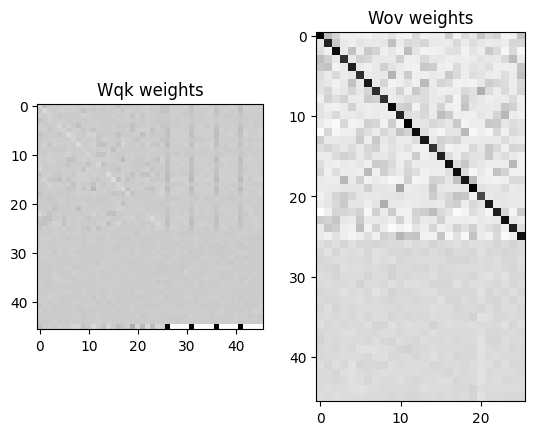

In [763]:
plt.subplot(1,2,1)
plt.imshow(Wqk[499].squeeze(0), cmap='grey_r')
plt.title('Wqk weights')
plt.subplot(1,2,2)
plt.imshow(Wov[499].squeeze(0), cmap='grey_r')
plt.title('Wov weights')

## Loading the saved Train_dataset

In [764]:
saved = torch.load("10. Train_dataset.pt")
train_data = saved['train_data']
train_labels = saved['train_labels']

**Let's use following gradient information to manually compute gradients to understand it further**

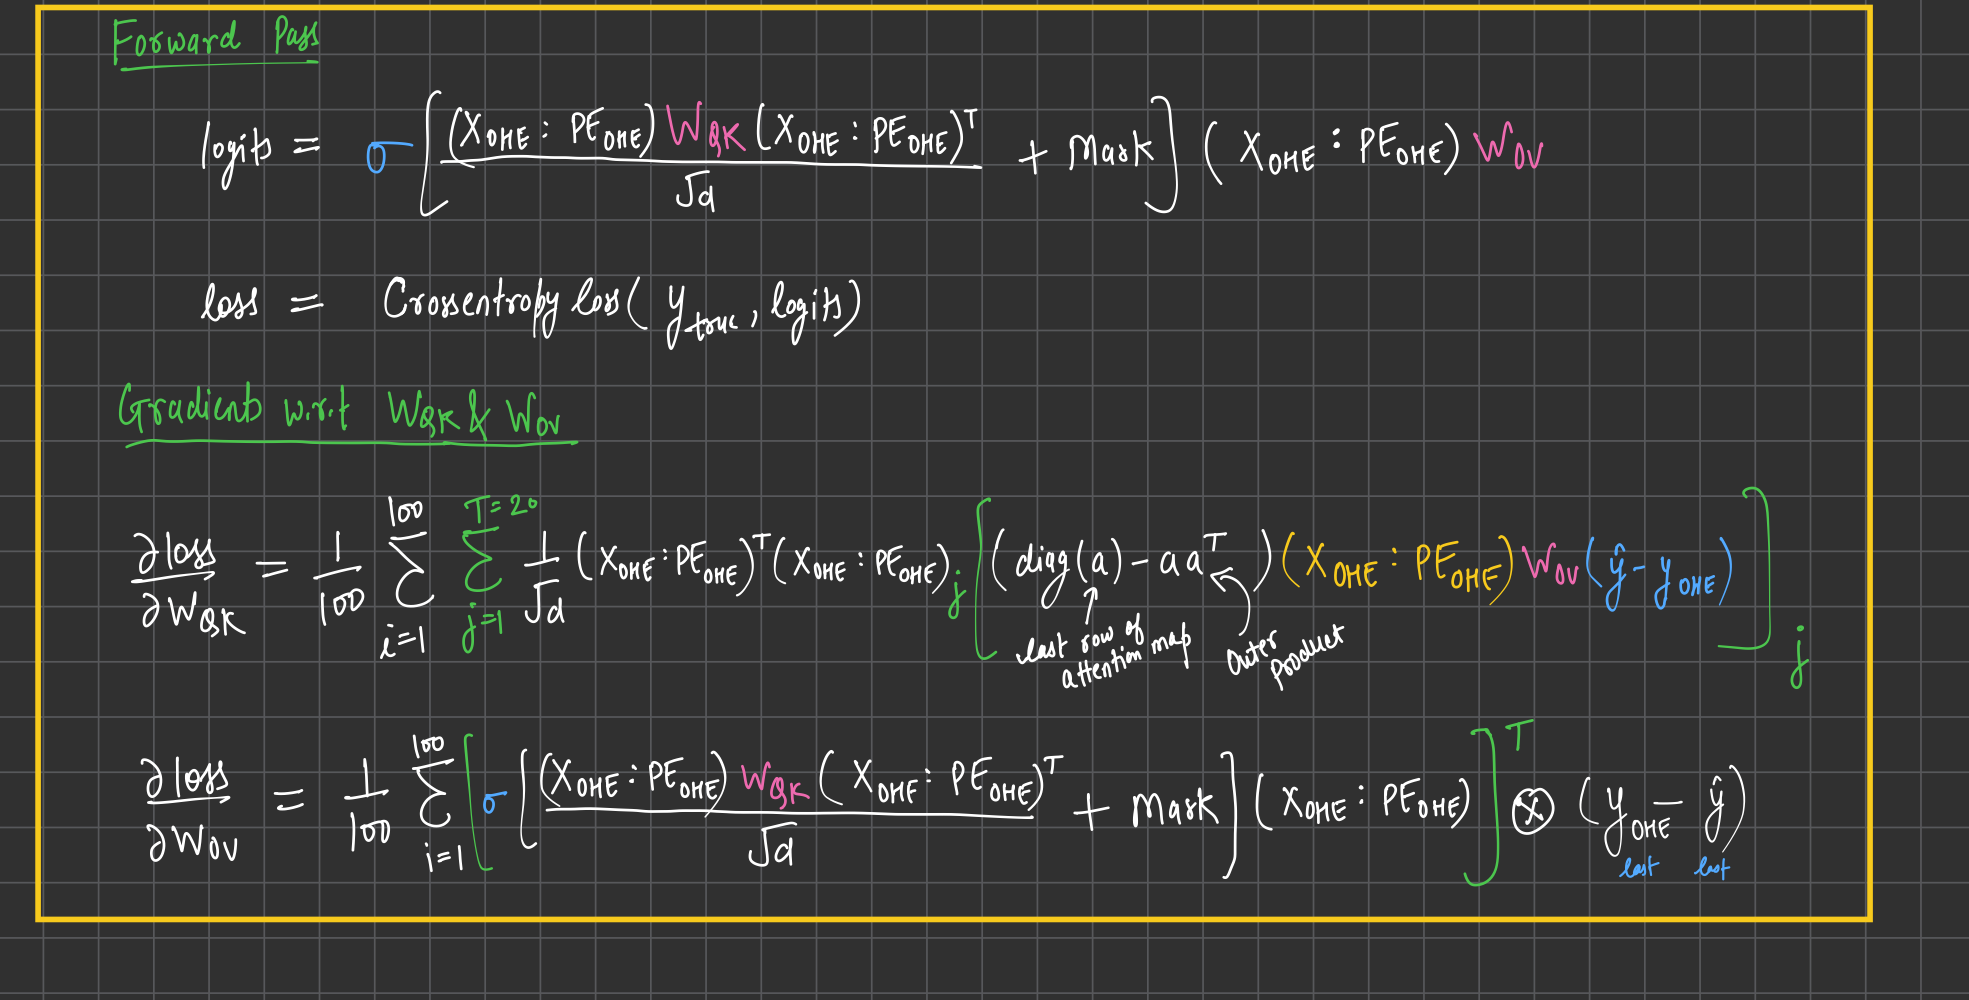

**Visual of a sample datapoint.**

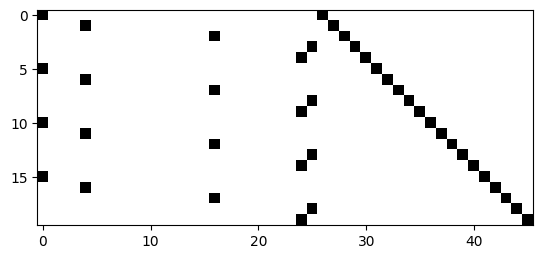

In [765]:
seq = train_data[0]
X_input = torch.zeros(20, 26)
for i in range(0, len(X_input)):
    X_input[i][seq[i]] = 1
    
pe = torch.eye(20)
X_input = torch.cat([X_input, pe], dim=1)
plt.imshow(X_input, cmap='gray_r')

### computing gradients using the below gradient formula

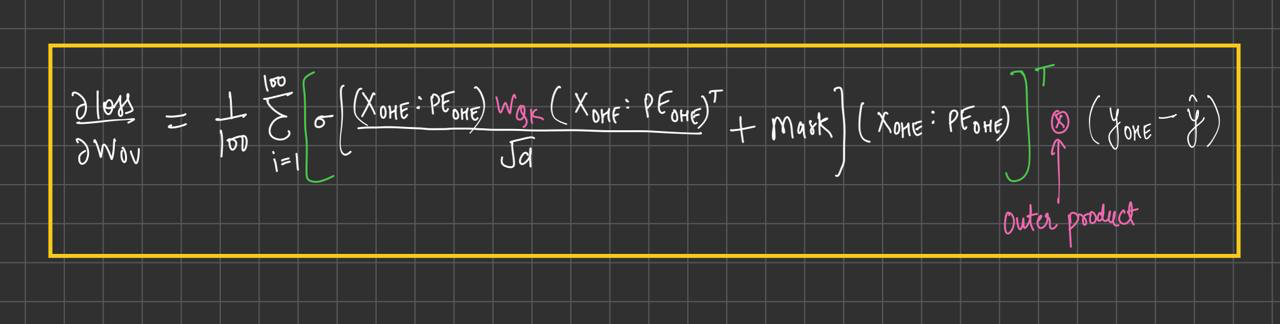

/var/folders/8d/s3zqx3p91zv0zgpd_hh3hpwh0000gn/T/ipykernel_1193/4034265226.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grad_Wov_manual += logits_before_ov[-1].unsqueeze(1) @ torch.tensor(del_y).unsqueeze(0)


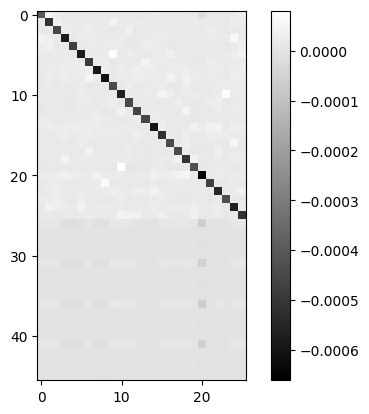

In [788]:
def embedding_of_sequence(seq, vocab_size=26, context_len=20):
    X_input = torch.zeros(context_len, vocab_size)
    for i in range(0, len(X_input)):
        X_input[i][seq[i]] = 1
    pe = torch.eye(context_len)
    X_input = torch.cat([X_input, pe], dim=1)
    return X_input

grad_Wov_manual = 0
epoch_number =  499
for i in range(len(train_data)):
    seq = embedding_of_sequence(train_data[i])
    # mask = torch.triu(torch.ones(20, 20), diagonal=1).bool()
    scores = (seq @ Wqk[epoch_number].squeeze(0) @ seq.T) / (len(seq[0]) ** 0.5)
    # scores = scores.masked_fill(mask == 1, float('-1e9'))
    attn_weights = torch.softmax(scores, dim=-1)
    logits_before_ov = attn_weights @ seq
    final_logits = logits_before_ov @ Wov[epoch_number].squeeze(0)
    y_hat = torch.softmax(final_logits[-1], dim=-1)
    y_ohe =  torch.zeros(26)
    y_ohe[train_labels[i][-1]] = 1
    del_y = y_hat - y_ohe
    grad_Wov_manual += logits_before_ov[-1].unsqueeze(1) @ torch.tensor(del_y).unsqueeze(0)

grad_Wov_manual/= len(train_data)

plt.imshow(grad_Wov_manual, cmap='grey')
plt.colorbar()


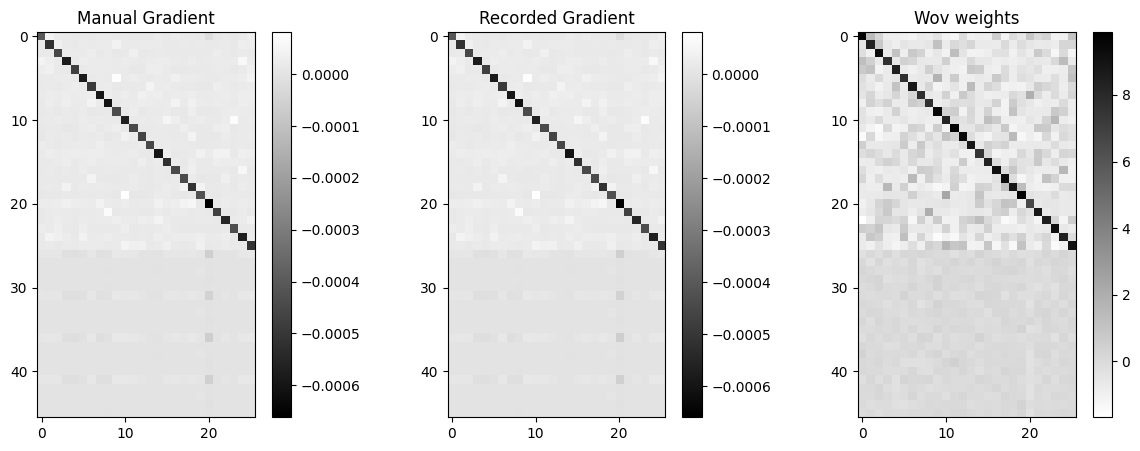

In [789]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(grad_Wov_manual, cmap='gray')
plt.title('Manual Gradient')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(grad_Wov[epoch_number], cmap='gray')
plt.title('Recorded Gradient')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(Wov[epoch_number].squeeze(0), cmap='gray_r')
plt.title('Wov weights')
plt.colorbar()


### Let's find gradient with respect to Wqk

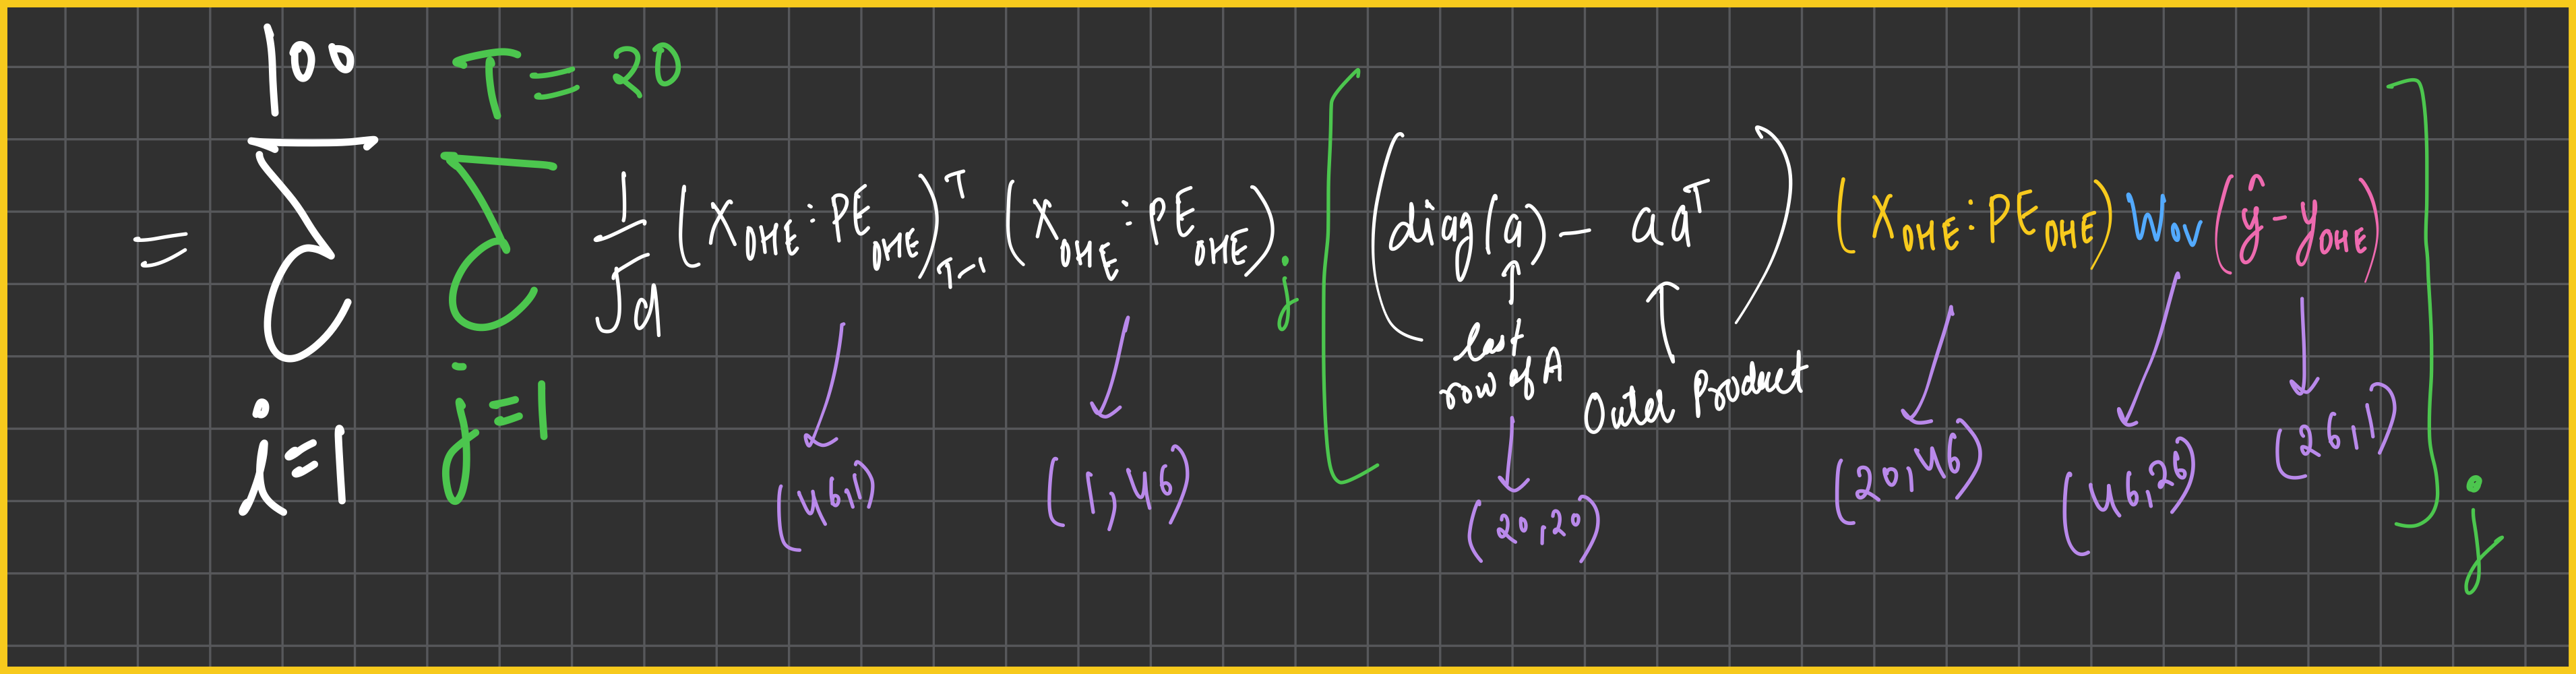

In [ ]:
epoch_number = 499
grad_Wqk_manual = torch.zeros_like(Wqk[epoch_number].squeeze(0))
for i in range(1):

    seq = embedding_of_sequence(train_data[i])
    mask = torch.triu(torch.ones(20, 20), diagonal=1).bool()
    scores = (seq @ Wqk[epoch_number].squeeze(0) @ seq.T) / (len(seq[0]) ** 0.5)
    scores = scores.masked_fill(mask == 1, float('-1e9'))
    attn_weights = torch.softmax(scores, dim=-1)
    logits_before_ov = attn_weights @ seq
    final_logits = logits_before_ov @ Wov[epoch_number].squeeze(0)

    y_hat = torch.softmax(final_logits[-1], dim=-1)
    y_ohe =  torch.zeros(26)
    y_ohe[train_labels[i][-1]] = 1
    del_z = y_hat - y_ohe # gradients with respect to logits z.

    del_h = Wov[epoch_number].squeeze(0) @ del_z # (46, 26) @ (26,) => (46) 
    del_attn = seq @ del_h # (20, 46) @ (46,) => (20,) 

    jocboian = torch.diag(attn_weights[-1]) - torch.outer(attn_weights[-1], attn_weights[-1]) # (20, 20)
    del_scores = (del_attn.unsqueeze(0) @ jocboian).squeeze(0) # (1, 20) @ (20, 20) => (1, 20) => (20,)

    T = len(seq); 
    for j in range(1):
        grad_Wqk_manual += (seq[-1].unsqueeze(1) @ seq[j].unsqueeze(0)) # * del_scores[j] / (len(seq[0]) ** 0.5)

grad_Wqk_manual /= len(train_data)



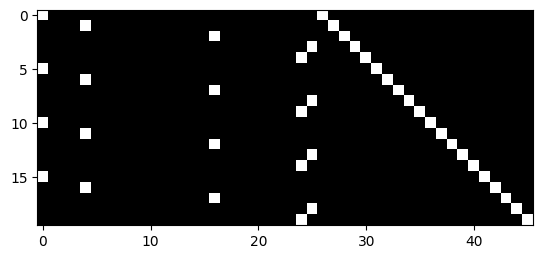

In [949]:
plt.imshow(seq, cmap='gray')

In [ ]:
for i in range(len(seq)):
    for j in range(26):
        if seq[i][j] == 1:
            print(j)

0
4
16
25
24
0
4
16
25
24
0
4
16
25
24
0
4
16
25
24


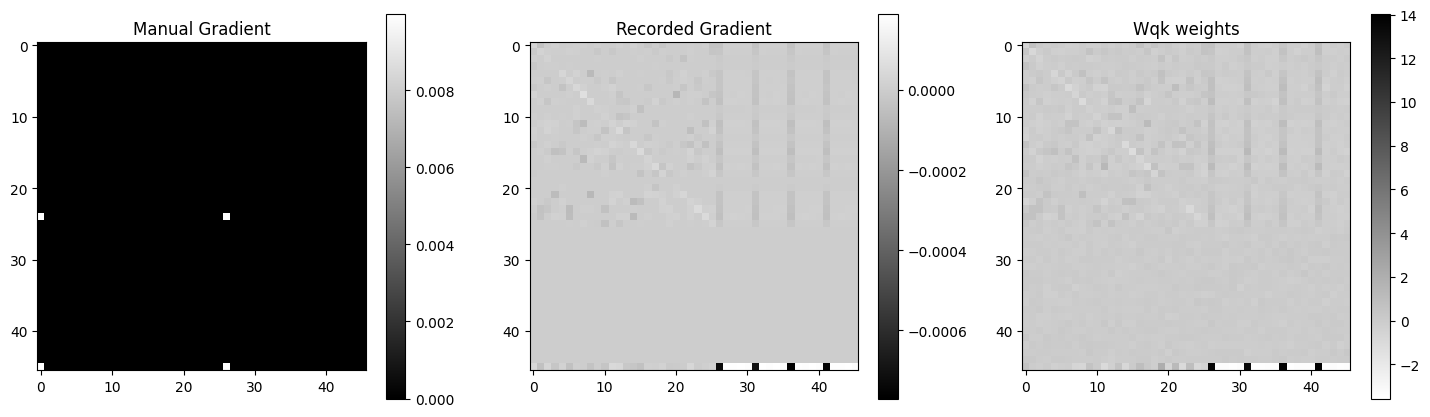

In [951]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.imshow(grad_Wqk_manual, cmap='grey')
plt.title('Manual Gradient')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(grad_Wqk[epoch_number], cmap='grey')
plt.title('Recorded Gradient')
plt.subplot(1,3,3)
plt.colorbar()

plt.imshow(Wqk[epoch_number].squeeze(0), cmap='grey_r')
plt.title('Wqk weights')
plt.colorbar()


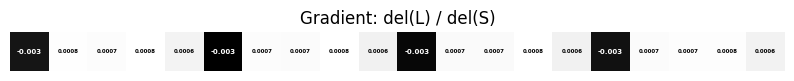

In [868]:
# Convert 1D vector → 2D (1, N)
mat = del_scores.unsqueeze(0)     # shape: (1, N)
mat_np = mat.cpu().numpy()

plt.figure(figsize=(10,20))
plt.imshow(mat_np, cmap='grey')
plt.title('Gradient: del(L) / del(S)')
plt.axis('off')

# Annotate each cell
rows, cols = mat_np.shape
for j in range(cols):

    if j%5 == 0: 
        plt.text(
            j, 0,
            f"{mat_np[0, j]:.3f}",
            ha='center', va='center',
            color='white', fontsize=5, fontweight='bold'
        )
    else:   
        plt.text(
            j, 0,
            f"{mat_np[0, j]:.4f}",
            ha='center', va='center',
            color='black', fontsize=4, fontweight='extra bold'
        )

ax = plt.gca()
ax.set_xticks([]); ax.set_yticks([])
plt.show()



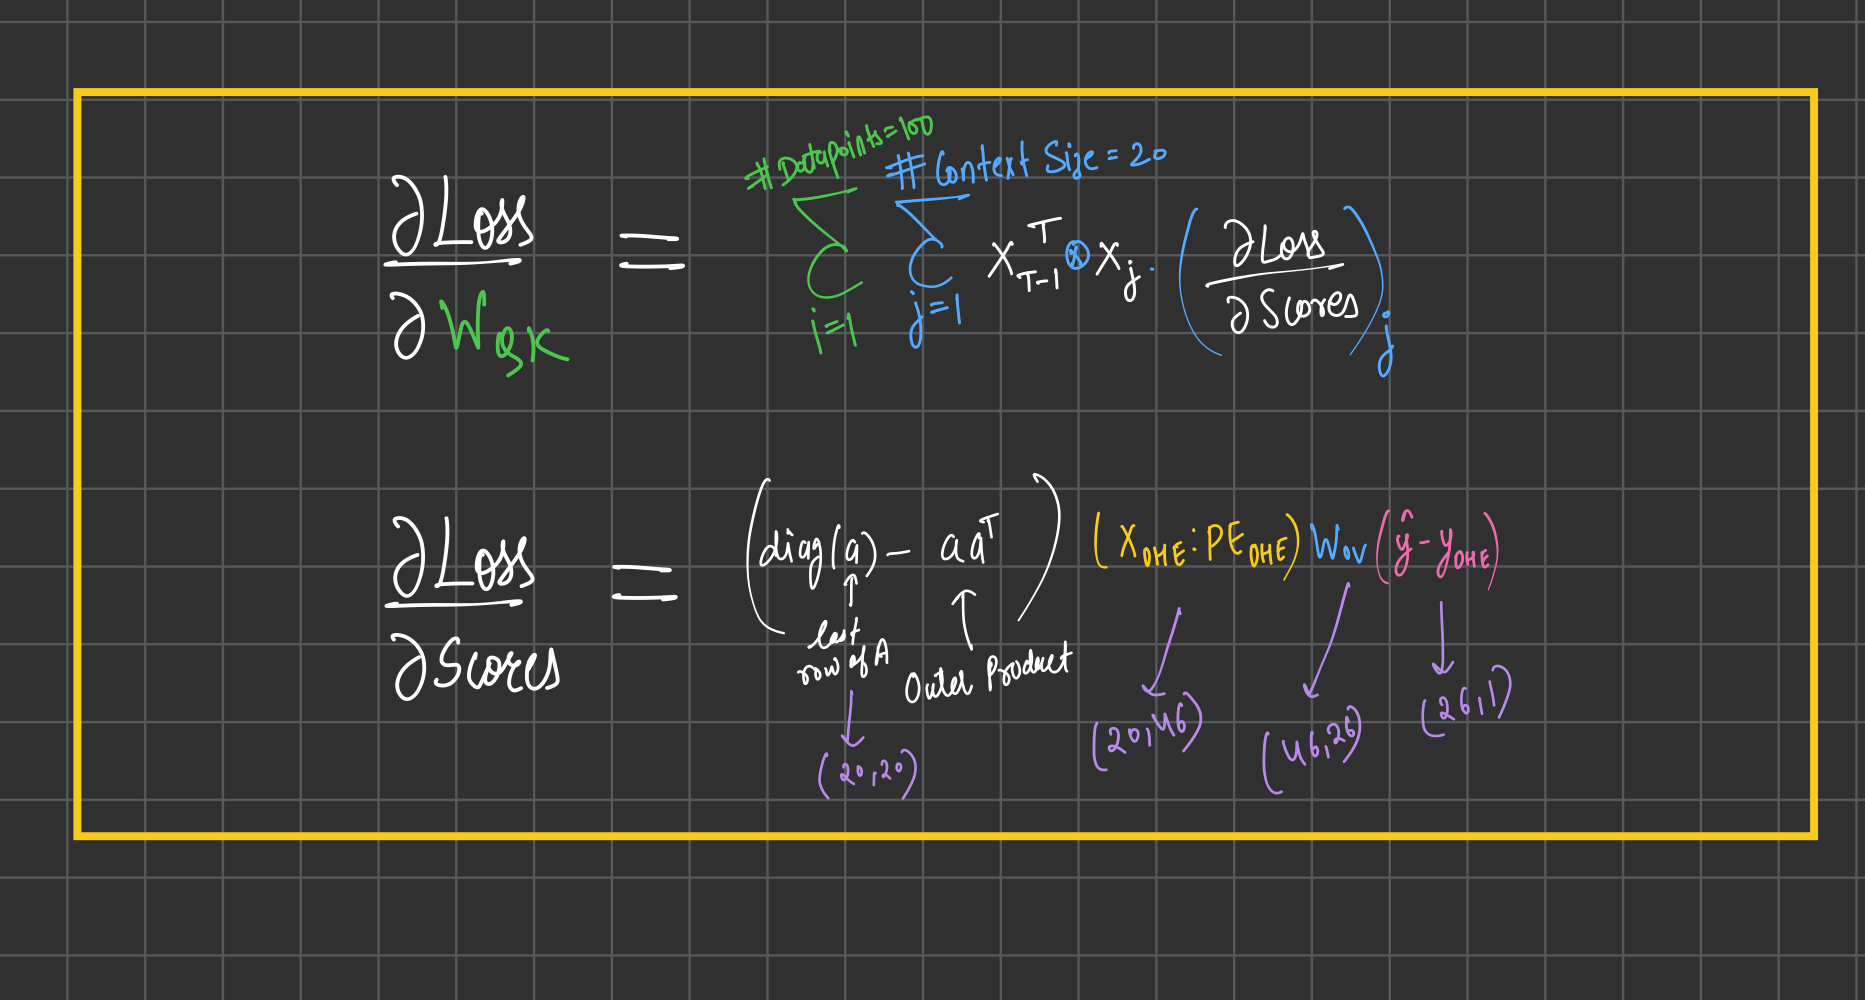

## Let's plt three different parts of grdient of loss function with respect to Scores

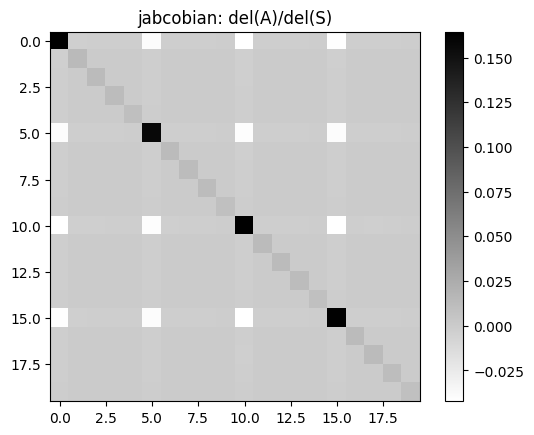

In [876]:
plt.imshow(jocboian, cmap='gray_r')
plt.title('jabcobian: del(A)/del(S)')
plt.colorbar()

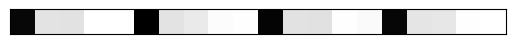

In [ ]:
plt.imshow(del_attn.unsqueeze(0), cmap='gray')
plt.title('')
ax = plt.gca()
ax.set_xticks([]); ax.set_yticks([])
plt.show()

In [ ]:
plt.imshow(del_h.unsqueeze(0), cmap='gray')
plt.title('')
ax = plt.gca()
ax.set_xticks([]); ax.set_yticks([])
plt.show()

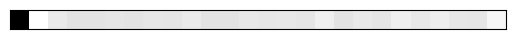

In [873]:
plt.imshow(del_z.unsqueeze(0), cmap='gray')
plt.title('')
ax = plt.gca()
ax.set_xticks([]); ax.set_yticks([])
plt.show()

In [ ]:
del_z

## Let's do the same for gradient with respect to Wov

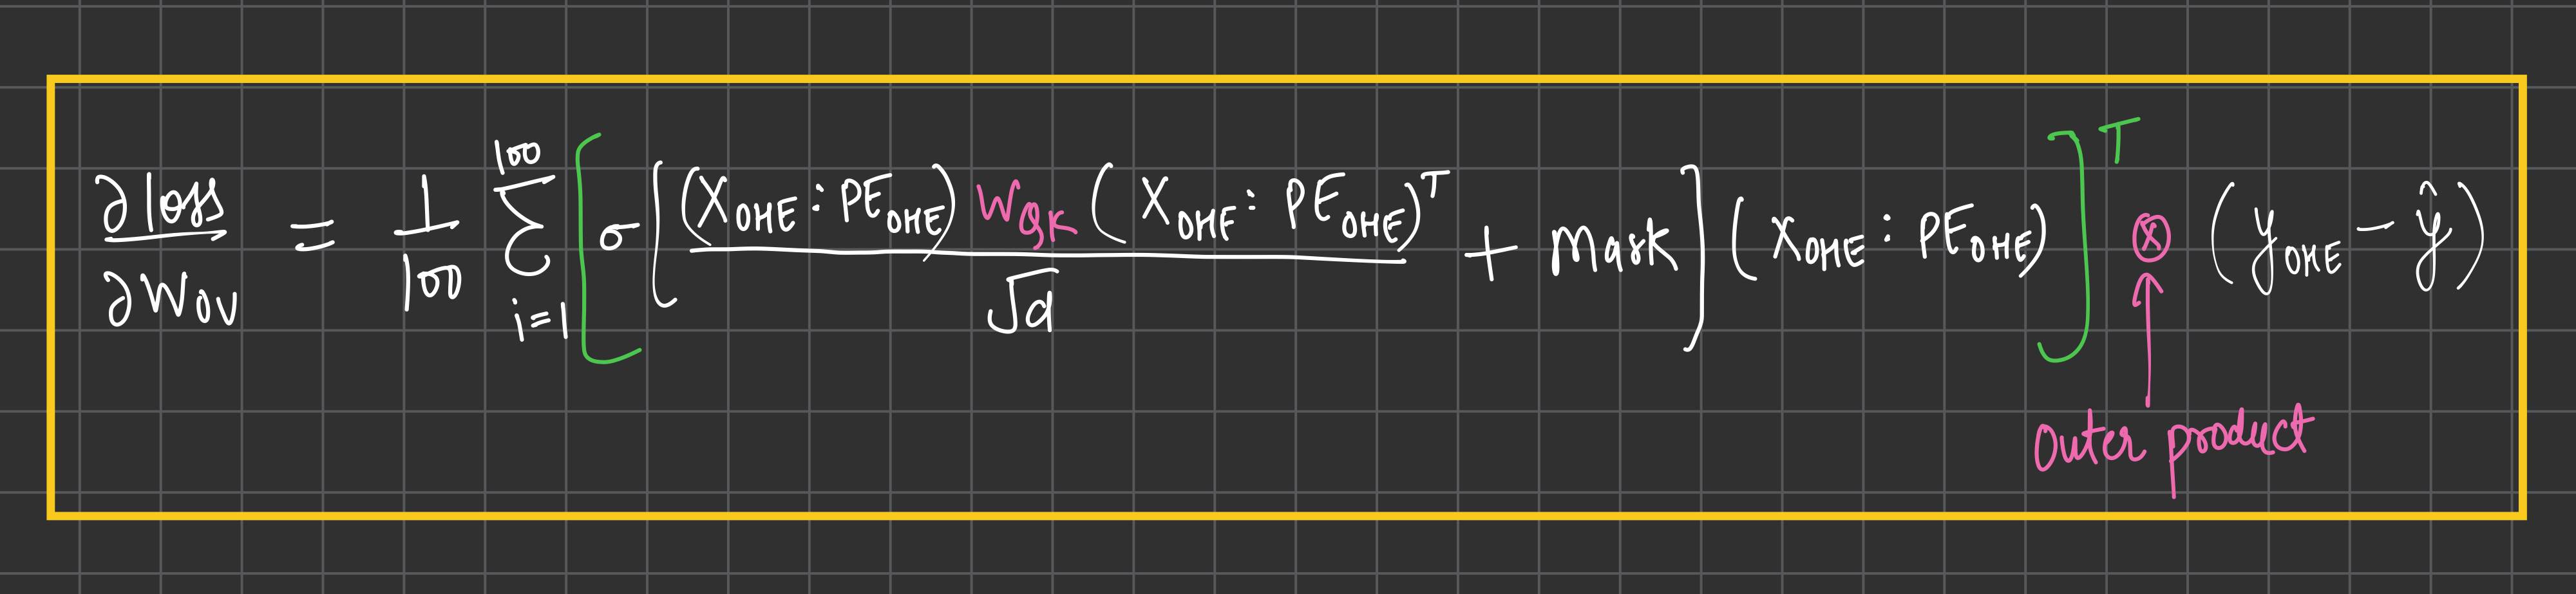

/var/folders/8d/s3zqx3p91zv0zgpd_hh3hpwh0000gn/T/ipykernel_1193/4091699129.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grad_Wov_manual += logits_before_ov[-1].unsqueeze(1) @ torch.tensor(del_y).unsqueeze(0)


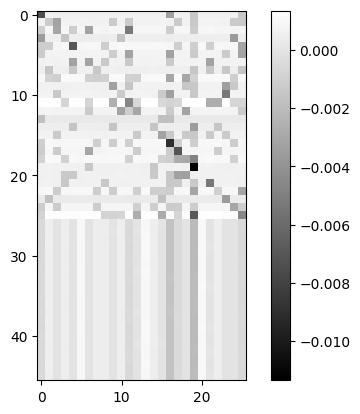

In [943]:
def embedding_of_sequence(seq, vocab_size=26, context_len=20):
    X_input = torch.zeros(context_len, vocab_size)
    for i in range(0, len(X_input)):
        X_input[i][seq[i]] = 1
    pe = torch.eye(context_len)
    X_input = torch.cat([X_input, pe], dim=1)
    return X_input

grad_Wov_manual = 0
epoch_number =  0
for i in range(50):
    seq = embedding_of_sequence(train_data[i])
    # mask = torch.triu(torch.ones(20, 20), diagonal=1).bool()
    scores = (seq @ Wqk[epoch_number].squeeze(0) @ seq.T) / (len(seq[0]) ** 0.5)
    # scores = scores.masked_fill(mask == 1, float('-1e9'))
    attn_weights = torch.softmax(scores, dim=-1)
    logits_before_ov = attn_weights @ seq
    final_logits = logits_before_ov @ Wov[epoch_number].squeeze(0)
    y_hat = torch.softmax(final_logits[-1], dim=-1)
    y_ohe =  torch.zeros(26)
    y_ohe[train_labels[i][-1]] = 1
    del_y = y_hat - y_ohe
    grad_Wov_manual += logits_before_ov[-1].unsqueeze(1) @ torch.tensor(del_y).unsqueeze(0)

grad_Wov_manual/= len(train_data)

plt.imshow(grad_Wov_manual, cmap='grey')
plt.colorbar()


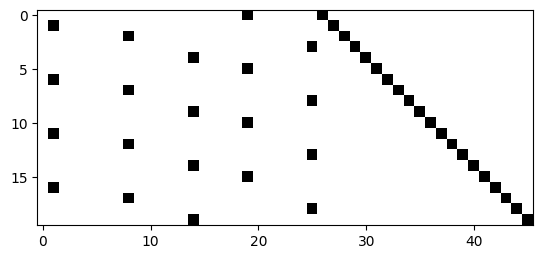

In [880]:
plt.imshow(seq, cmap='gray_r')

In [881]:
plt.imshow(logits_before_ov[-1].unsqueeze(0), cmap='gray_r')
ax = plt.gca()
ax.set_xticks([]); ax.set_yticks([])

[]

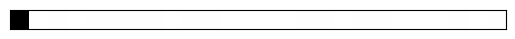

In [883]:
plt.imshow(del_y.unsqueeze(0), cmap='gray')
ax = plt.gca()
ax.set_xticks([]); ax.set_yticks([])
plt.show()

In [752]:
del_y

tensor([-0.9629,  0.0422,  0.0360,  0.0385,  0.0375,  0.0373,  0.0382,  0.0381,
         0.0383,  0.0366,  0.0374,  0.0394,  0.0420,  0.0404,  0.0397,  0.0382,
         0.0366,  0.0398,  0.0362,  0.0370,  0.0401,  0.0401,  0.0410,  0.0360,
         0.0389,  0.0374])

# Outer Product between tokens.

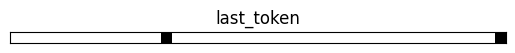

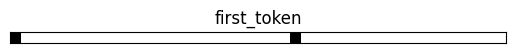

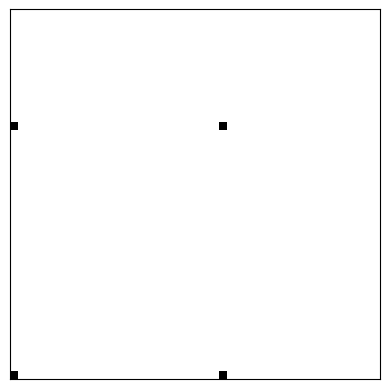

In [ ]:
last, first = -1, 0

plt.imshow(seq[last].unsqueeze(1).T, cmap='gray_r')
plt.title('last_token')
# plt.axis('off')
ax = plt.gca()
ax.set_xticks([]); ax.set_yticks([])
plt.show()

plt.imshow(seq[first].unsqueeze(1).T, cmap='gray_r')
plt.title('first_token')
# plt.axis('off')
ax = plt.gca()
ax.set_xticks([]); ax.set_yticks([])
plt.show()

outer1 = seq[last].unsqueeze(1) @ seq[first].unsqueeze(0)
plt.imshow(outer1, cmap='gray_r')
plt.colorbar()
plt.show()

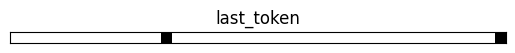

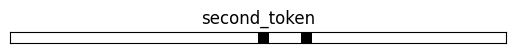

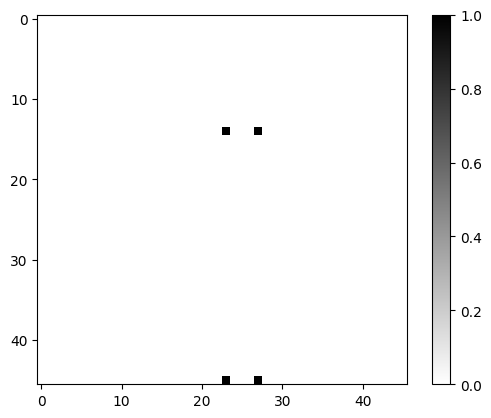

In [890]:
last, first = -1, 1

plt.imshow(seq[last].unsqueeze(1).T, cmap='gray_r')
plt.title('last_token')
# plt.axis('off')
ax = plt.gca()
ax.set_xticks([]); ax.set_yticks([])
plt.show()

plt.imshow(seq[first].unsqueeze(1).T, cmap='gray_r')
plt.title('second_token')
# plt.axis('off')
ax = plt.gca()
ax.set_xticks([]); ax.set_yticks([])
plt.show()

outer1 = seq[last].unsqueeze(1) @ seq[first].unsqueeze(0)
plt.imshow(outer1, cmap='gray_r')
plt.colorbar()
plt.show()

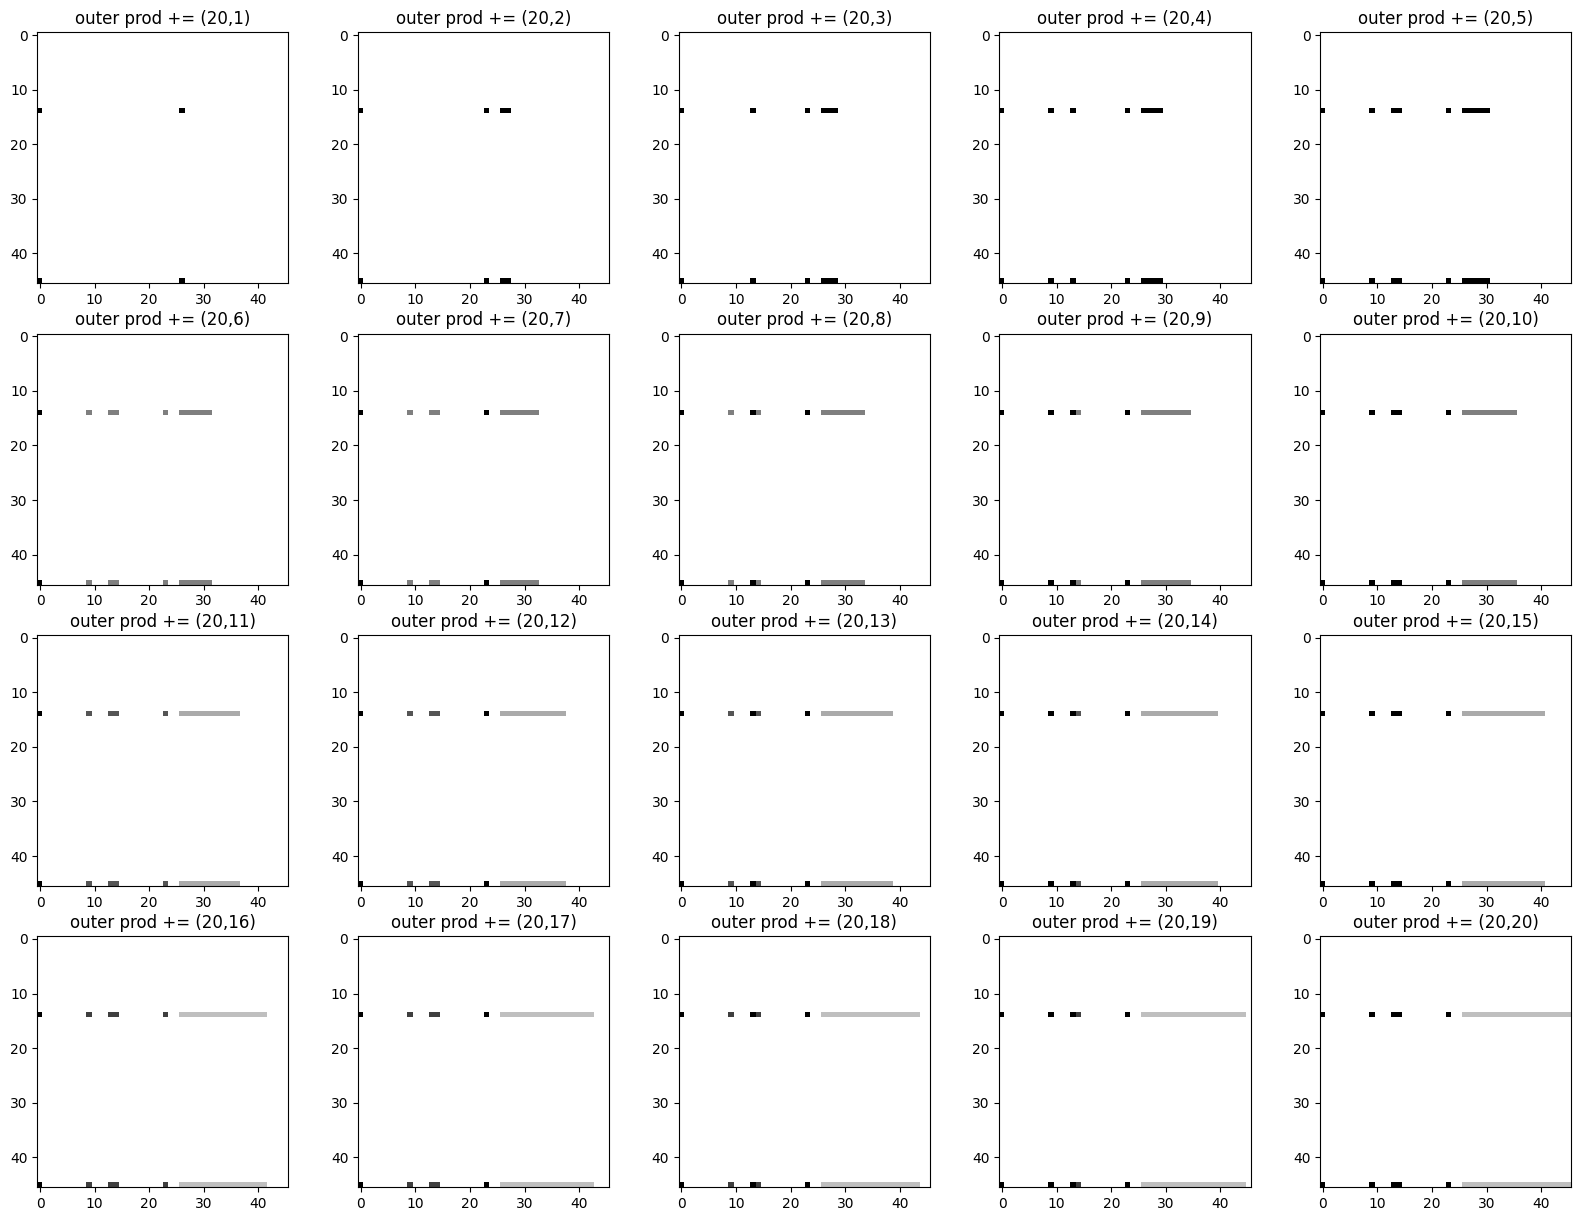

In [ ]:
outer = 0
plt.figure(figsize=(20, 15))
for i in range(len(seq)):
    plt.subplot(4,5,i+1)    
    outer += seq[-1].unsqueeze(1) @ seq[i].unsqueeze(0)
    plt.imshow(outer, cmap='gray_r')
    plt.title(f'outer prod += (20,{i+1})')
    # plt.axis('off')

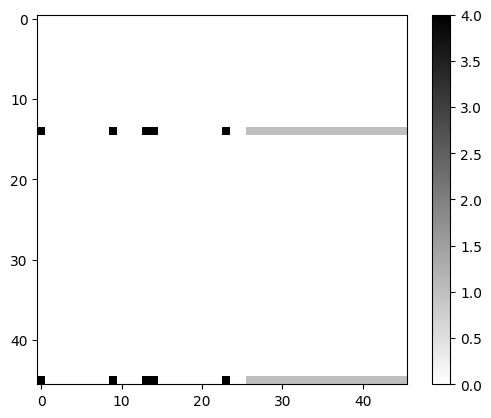

In [ ]:
plt.imshow(outer, cmap='gray_r')
plt.colorbar()